### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import pickle
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

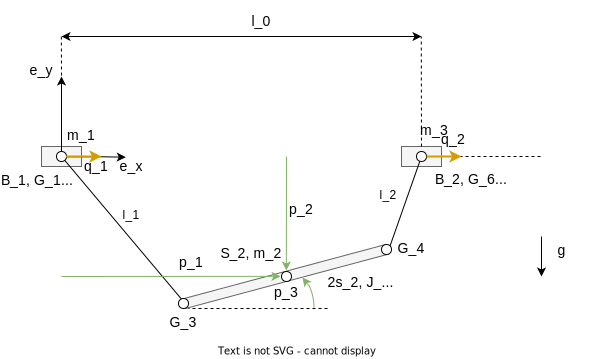

In [2]:
from IPython.display import Image
from IPython.core.display import SVG
SVG(filename='ODE_flatness_analysis_simulation_diagram.svg')

In [3]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 3 # number of passive coordinates (not directly actuated)
nq = 2 # number of actuated coordinates
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates



# vector of control inputs
aa = st.symb_vector("a1:{0}".format(4+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
tthetaddd = st.time_deriv(ttheta, ttheta, order=3) ##:T
tthetadddd = st.time_deriv(ttheta, ttheta, order=4) ##:T

st.make_global(ttheta, tthetad, tthetadd, tthetaddd, tthetadddd)

QQ = st.symb_vector("Q1:{0}".format(n+1)) ##:T # vector of generalized foces
st.make_global(QQ)

---

---

---

---

---

---

---

In [4]:
# symbols for analytic equations
params = sp.symbols('s2, m1, m2, m3, J1, J2, J3, mc1b, mc2b d1, d4, l0, l1, l2, l3, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2, tau3, tau4 = ttau = st.symb_vector("tau1, tau2, tau3, tau4")

Specify the geometry (joints G and centers of masses S)

#### Quasistatic state feedback control

In [5]:
# load model etc. from pickle of flatness analysis notebook
with open("flatness_analysis_control.pcl", "rb") as pfile:
    data = pickle.load(pfile)
    locals().update(data)

Nonlinearities are chosen to be the new inputs of the system:
\begin{align}
    v_1 &:= \ddot{p}_1 = \ddot{y}_1 \\
    v_2 &:= \ddddot{p}_2 = \ddddot{y}_2 \\
    v_3 &:= \ddot{p}_3 = \ddot{y}_3 \\
    v_4 &:= \ddot{q}_1 = \ddot{y}_4 
\end{align}

In [6]:
vv = st.symb_vector("v1:{0}".format(4+1)) # vector of new inputs
vvd = st.time_deriv(vv, vv)
vvdd = st.time_deriv(vv, vv, order=2)

st.make_global(vv, vvd, vvdd)

In [7]:
ttaud = st.time_deriv(ttau, ttau)
ttaudd = st.time_deriv(ttau, ttau, order=2)

st.make_global(ttaud, ttaudd)

In [8]:
xx_ext = sp.Matrix(len(mod.xx) + 2*len(mod.tau) + 2*len(vv), 1, [*mod.xx, *ttau, *ttaud, *vv, *vvd])
fg_ext = sp.Matrix(len(mod.state_eq) + 2*len(mod.tau) + 2*len(vv), 1, [*mod.state_eq, *ttaud, *ttaudd, *vvd, *vvdd])

In [9]:
y1_ext = xx_ext[0]
ydot1_ext = st.lie_deriv(y1_ext, fg_ext, xx_ext)
yddot1_ext = st.lie_deriv(ydot1_ext, fg_ext, xx_ext)
ydddot1_ext = st.lie_deriv(yddot1_ext, fg_ext, xx_ext)
yddddot1_ext = st.lie_deriv(ydddot1_ext, fg_ext, xx_ext)

ydot1_ext.s ##:
yddot1_ext.s ##:
ydddot1_ext.s ##:
yddddot1_ext.s ##:

---

---

---

---

In [10]:
y2_ext = xx_ext[1]
ydot2_ext = st.lie_deriv(y2_ext, fg_ext, xx_ext)
yddot2_ext = st.lie_deriv(ydot2_ext, fg_ext, xx_ext)
ydddot2_ext = st.lie_deriv(yddot2_ext, fg_ext, xx_ext)
yddddot2_ext = st.lie_deriv(ydddot2_ext, fg_ext, xx_ext)

ydot2_ext.s ##:
yddot2_ext.s ##:
ydddot2_ext.s ##:
yddddot2_ext.s ##:

---

---

---

---

In [11]:
y3_ext = xx_ext[2]
ydot3_ext = st.lie_deriv(y3_ext, fg_ext, xx_ext)
yddot3_ext = st.lie_deriv(ydot3_ext, fg_ext, xx_ext)
ydddot3_ext = st.lie_deriv(yddot3_ext, fg_ext, xx_ext)
yddddot3_ext = st.lie_deriv(ydddot3_ext, fg_ext, xx_ext)

ydot3_ext.s ##:
yddot3_ext.s ##:
ydddot3_ext.s ##:
yddddot3_ext.s ##:

---

---

---

---

In [12]:
y4_ext = xx_ext[3]
ydot4_ext = st.lie_deriv(y4_ext, fg_ext, xx_ext)
yddot4_ext = st.lie_deriv(ydot4_ext, fg_ext, xx_ext)
ydddot4_ext = st.lie_deriv(yddot4_ext, fg_ext, xx_ext)
yddddot4_ext = st.lie_deriv(ydddot4_ext, fg_ext, xx_ext)

ydot4_ext.s ##:
yddot4_ext.s ##:
ydddot4_ext.s ##:
yddddot4_ext.s ##:

---

---

---

---

In [13]:
# v_j = m_i * tau_i + n_i

In [14]:
m1 = yddot4_ext.diff(tau1)
n1 = yddot4_ext.subs(tau1, 0)
tau1_impl = (v4 - n1)/ m1
tau1_impl.s ##:
tau1_impl.co ##:

---

---

In [15]:
m2 = yddddot2_ext.diff(tau2)
n2 = yddddot2_ext.subs(tau2, 0)
tau2_impl = (v2 - n2)/ m2
tau2_impl.s ##:
tau2_impl.co ##:

---

---

In [16]:
m3 = yddot1_ext.diff(tau3)
n3 = yddot1_ext.subs(tau3, 0)
tau3_impl = (v1 - n3)/ m3
tau3_impl.s ##:
tau3_impl.co ##:

---

---

In [17]:
m4 = yddot3_ext.diff(tau4)
n4 = yddot3_ext.subs(tau4, 0)
tau4_impl = (v3 - n4)/ m4
tau4_impl.s ##:
tau4_impl.co ##:

---

---

In [18]:
sol_tau134 = sp.solve((tau1-tau1_impl, tau3-tau3_impl, tau4-tau4_impl), tau1, tau3, tau4)

In [19]:
tau1_expl = sol_tau134[tau1].smplf
tau3_expl = sol_tau134[tau3].smplf
tau4_expl = sol_tau134[tau4].smplf

In [20]:
tau1_expl.s ##:
tau1_expl.co ##:
tau3_expl.s ##:
tau3_expl.co ##:
tau4_expl.s ##:
tau4_expl.co ##:

---

---

---

---

---

---

In [21]:
tau3_expl_dot = st.lie_deriv(tau3_expl, fg_ext, xx_ext)
tau3_expl_dot.s ##:
tau3_expl_dot.co ##:
tau3_expl_ddot = st.lie_deriv(tau3_expl_dot, fg_ext, xx_ext)
tau3_expl_ddot.s ##:
tau3_expl_ddot.co ##:

tau4_expl_dot = st.lie_deriv(tau4_expl, fg_ext, xx_ext)
tau4_expl_dot.s ##:
tau4_expl_dot.co ##:
tau4_expl_ddot = st.lie_deriv(tau4_expl_dot, fg_ext, xx_ext)
tau4_expl_ddot.s ##:
tau4_expl_ddot.co ##:

---

---

---

---

---

---

---

---

In [22]:
tau2_expl = tau2_impl.subz([tauddot3, tauddot4, taudot3, taudot4, tau1, tau3, tau4], 
                             [tau3_expl_ddot, tau4_expl_ddot, tau3_expl_dot, tau4_expl_dot, tau1_expl, tau3_expl, tau4_expl])
tau2_expl.s ##:
tau2_expl.co ##:

mc2 = tau2_expl.diff(tau2)
nc2 = tau2_expl.subs(tau2, 0)

tau2_expl = 1/(1-mc2) * nc2
tau2_expl.s ##:
tau2_expl.co ##:

---

---

---

---

#### State feedback for control

In [23]:
# define symbols for measured states
p_meas = st.symb_vector("pm1:{0}".format(3+1)) # error vector of passive coordinates
q_meas = st.symb_vector("qm1:{0}".format(2+1)) # error vector of actuated coordinates

meas_states = st.row_stack(p_meas, q_meas)
meas_states_d = st.time_deriv(meas_states, meas_states)
meas_states_dd = st.time_deriv(meas_states, meas_states, order=2)
meas_states_ddd = st.time_deriv(meas_states, meas_states, order=3)
meas_states_dddd = st.time_deriv(meas_states, meas_states, order=4)

st.make_global(meas_states, meas_states_d, meas_states_dd, meas_states_ddd, meas_states_dddd)

# define symbols for reference trajectory states
p_ref = st.symb_vector("pr1:{0}".format(3+1)) # error vector of passive coordinates
q_ref = st.symb_vector("qr1:{0}".format(2+1)) # error vector of actuated coordinates

ref_states = st.row_stack(p_ref, q_ref)
ref_states_d = st.time_deriv(ref_states, ref_states)
ref_states_dd = st.time_deriv(ref_states, ref_states, order=2)
ref_states_ddd = st.time_deriv(ref_states, ref_states, order=3)
ref_states_dddd = st.time_deriv(ref_states, ref_states, order=4)

st.make_global(ref_states, ref_states_d, ref_states_dd, ref_states_ddd, ref_states_dddd)

#### Linear feedback error:
$$
e := y - y_{\text{ref}}
$$

#### Error dynamics:
$$
e^{(n)} + c_{n-1} e^{(n-1)} + ... + c_{1} \dot{e} + c_{0} e = 0 
\Leftrightarrow y^{(n)} = y_{\text{ref}}^{(n)} - c_{n-1} e^{(n-1)} - ... - c_{1} \dot{e} - c_{0} e
$$

In [24]:
from sympy.matrices.dense import matrix_multiply_elementwise as elmul
# coefficients for error dynamics
# Polynome: s^2 + c_i[1] s + c_i[0] s
cp1 = [1, 2]
cp3 = [1, 2]
cq1 = [1, 2]
c2 = sp.Matrix([cp1, [0, 0], cp3, cq1, [0, 0]])

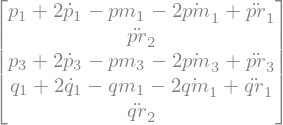

---

In [25]:
v134 = ref_states_dd - elmul(c2[:, 1], (meas_states_d - tthetad)) - elmul(c2[:, 0], (meas_states - ttheta)) ##:

In [26]:
v1_expr, dummy, v3_expr, v4_expr, dummy = v134

##### Quasi static state feedback for $\dot{v}_1$, $\ddot{v}_1$, $\dot{v}_3$, $\ddot{v}_3$:
\begin{align}
    \ddot{e} + c_1 \dot{e} + c_0 e &= 0 \\
    e^{(3)} + c_1 \ddot{e} + c_0 \dot{e} &= 0 \\
    e^{(3)} + c_1 (-c_1 \dot{e} - c_0 e) + c_0 \dot{e} &= 0 \\
    e^{(3)} - c_1^2 \dot{e} + c_0 \dot{e} - c_0 c_1 e &= 0 \\
    e^{(3)} + (c_0 - c_1^2) \dot{e} - c_0 c_1 e &= 0 \\
    e^{(4)} + (c_0 - c_1^2) \ddot{e} - c_0 c_1 \dot{e} &= 0 \\
    e^{(4)} + (c_0 - c_1^2) (-c_1 \dot{e} - c_0 e) - c_0 c_1 \dot{e} &= 0 \\
    e^{(4)} + (c_1^3 - 2 c_0 c_1) \dot{e} + (c_0 c_1^2 - c_0^2) e &= 0 \\
    \Rightarrow y^{(3)} &= y_{\text{ref}}^{(3)} - (c_0 - c_1^2) \dot{e} + c_0 c_1 e \\
    \Rightarrow y^{(4)} &= y_{\text{ref}}^{(4)} - (c_1^3 - 2 c_0 c_1) \dot{e} - (c_0 c_1^2 - c_0^2) e
\end{align}

In [27]:
c2_00 = elmul(c2[:, 0], c2[:, 0])
c2_01 = elmul(c2[:, 0], c2[:, 1])
c2_11 = elmul(c2[:, 1], c2[:, 1])
c2_111 = elmul(elmul(c2[:, 1], c2[:, 1]), c2[:, 1])
c2_011 = elmul(elmul(c2[:, 0], c2[:, 1]), c2[:, 1])

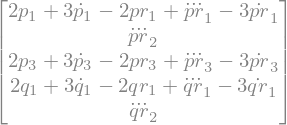

---

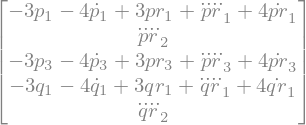

---

In [28]:
vdot134 = ref_states_ddd - elmul((c2[:, 0] - c2_11), (tthetad - ref_states_d)) + elmul(c2_01, (ttheta - ref_states)) ##:
vddot134 = ref_states_dddd - elmul((c2_111 - 2*c2_01), (tthetad - ref_states_d)) - elmul((c2_011 - c2_00), (ttheta - ref_states)) ##:

In [29]:
# vdot1 = y1^(3), vddot1 = y1^(4), vdot3 = y3^(3), vddot3 = y3^(4)
vdot1_expr, dummy, vdot3_expr, dummy, dummy = vdot134
vddot1_expr, dummy, vddot3_expr, dummy, dummy = vddot134

In [30]:
f_ext = fg_ext.subz0(ttau)
g_ext = fg_ext.jacobian(ttau)

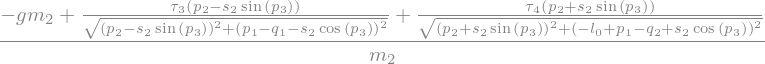

---

---

---

In [31]:
pddot2_expr = Lf2_y2 = st.lie_deriv(y2_ext, fg_ext, xx_ext, order=2) ##:
pddot2_expr.s ##:
pddot2_expr_traj = pddot2_expr.subz([tau3, tau4, v1, v3], [tau3_expl, tau4_expl, v1_expr, v3_expr])
pddot2_expr_traj.s ##:

In [32]:
pdddot2_expr = st.lie_deriv(pddot2_expr, fg_ext, xx_ext)
pdddot2_expr.s ##:
pdddot2_expr_traj = pdddot2_expr.subz([taudot3, taudot4, tau3, tau4, vdot1, vdot3, v1, v3], 
                                      [tau3_expl_dot, tau4_expl_dot, tau3_expl, tau4_expl, vdot1_expr, vdot3_expr,v1_expr, v3_expr])
pdddot2_expr_traj.s ##:
pdddot2_expr_traj.co ##:

---

---

---

In [43]:
dummy_p2_3 = pdddot2_expr.subz([taudot3, taudot4, tau3, tau4], [tau3_expl_dot, tau4_expl_dot, tau3_expl, tau4_expl])
dummy_p2_3.s

In [33]:
# coefficients for error dynamics of p2ddddot
# Polynome: s^4 + cp2[3] s^3 + cp2[2] s^2 + cp2[1] s + cp2[0] s
cp2 = [1, 4, 6, 4]

In [34]:
v2_expr = prddddot2 + cp2[3]*(prdddot2 - pdddot2) + cp2[2]*(prddot2 - pddot2) + cp2[1]*(prdot2 - pdot2) + cp2[0]*(pr2 - p2) ##:
v2_expr = v2_expr.subz([pddot2, pdddot2], [pddot2_expr_traj, pdddot2_expr_traj])
v2_expr.s ##:

---

---

In [35]:
### substitute new inputs into tau

In [36]:
tau1_expl.s ##:
qstat_tau1 = tau1_expl.subz([v1, v3, v4], [v1_expr, v3_expr, v4_expr])
qstat_tau1.s ##:
qstat_tau1 = qstat_tau1.subz([*tthetad, *ttheta], [*meas_states_d, *meas_states])
qstat_tau1 = qstat_tau1.smplf
qstat_tau1.s ##:
qstat_tau1.co ##:

---

---

---

---

In [37]:
tau3_expl.s ##:
qstat_tau3 = tau3_expl.subz([v1, v3], [v1_expr, v3_expr])
qstat_tau3.s ##:
qstat_tau3 = qstat_tau3.subz([*tthetad, *ttheta], [*meas_states_d, *meas_states])
qstat_tau3 = qstat_tau3.smplf
qstat_tau3.s ##:
qstat_tau3.co ##:

---

---

---

---

In [38]:
tau4_expl.s ##:
qstat_tau4 = tau4_expl.subz([v1, v3], [v1_expr, v3_expr])
qstat_tau4.s ##:
qstat_tau4 = qstat_tau4.subz([*tthetad, *ttheta], [*meas_states_d, *meas_states])
qstat_tau4 = qstat_tau4.smplf
qstat_tau4.s ##:
qstat_tau4.co ##:

---

---

---

---

In [39]:
tau2_expl.s ##:
qstat_tau2 = tau2_expl.subz([v1, v2, v3, v4, vdot1, vdot3, vddot1, vddot3], 
                             [v1_expr, v2_expr, v3_expr, v4_expr, vdot1_expr, vdot3_expr, vddot1_expr, vddot3_expr])
qstat_tau2 = qstat_tau2.subz([*tthetad, *ttheta], [*meas_states_d, *meas_states])
qstat_tau2.s ##:
qstat_tau2.co ##:

---

---

---

In [42]:
num1, den1 = sp.fraction(qstat_tau1)
num2, den2 = sp.fraction(qstat_tau2)
num3, den3 = sp.fraction(qstat_tau3)
num4, den4 = sp.fraction(qstat_tau4)

In [43]:
#########################

In [44]:
num2a, den2a = qstat_tau2.as_numer_denom()
diff_n = num2 - num2a
diff_d = den2 -den2a

In [45]:
den2.co ##:
den2a.co ##:

---

---

In [51]:
den1.s

In [50]:
den1

In [131]:
sp.cse?

In [132]:
num2.srn ##:
num2a.co ##:

---

---

In [133]:
diff_n.srn


KeyboardInterrupt



In [76]:
den2_cse_rp, (den2_cse_exprs,) = sp.cse(den2)

In [77]:
den2_cse_rp[:3]

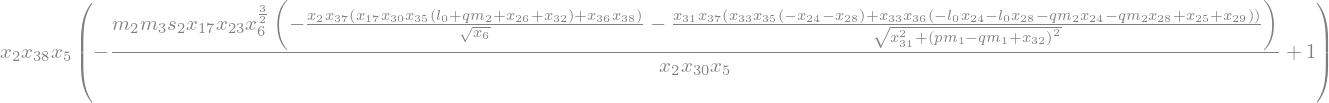

In [83]:
den2_cse_exprs

In [84]:
den2_cse_exprs_num, den2_cse_exprs_den = den2_cse_exprs.as_numer_denom()

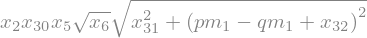

In [85]:
den2_cse_exprs_den

In [117]:
qstat_tau2_cse_rp, (qstat_tau2_cse_exprs,) = sp.cse(qstat_tau2)
qstat_tau2_cse_rp_reversed = qstat_tau2_cse_rp[::-1]

In [119]:
qstat_tau2_cse_rp[:4]

In [120]:
qstat_tau2_cse_rp_reversed[:4]

In [87]:
qstat_tau2_cse_exprs_num, qstat_tau2_cse_exprs_den = qstat_tau2_cse_exprs.as_numer_denom()

In [88]:
qstat_tau2_cse_exprs_den

In [116]:
qstat_tau2_cse_rp_reversed[:4]

In [121]:
qstat_tau2_den = qstat_tau2_cse_exprs_den.subs(qstat_tau2_cse_rp_reversed)

In [122]:
den2.co

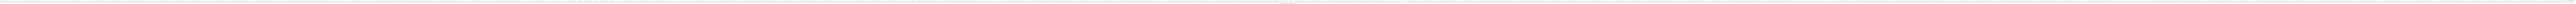

In [123]:
qstat_tau2_cse_exprs

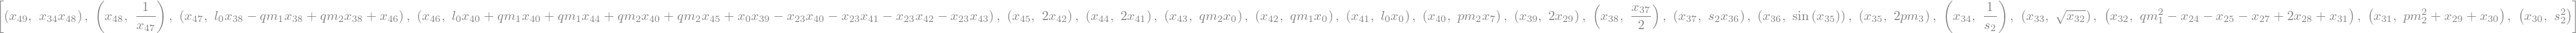

In [111]:
qstat_tau2_cse_rp.reverse()
qstat_tau2_cse_rp[:4]

In [126]:
sys_params = list(dict(J2=0.004553475, g=9.81, l0=0.3, m1=0.45, m2=0.557, m3=0.45, s2=0.15).items()) ##:

sys_params := [('J2', 0.004553475),
 ('g', 9.81),
 ('l0', 0.3),
 ('m1', 0.45),
 ('m2', 0.557),
 ('m3', 0.45),
 ('s2', 0.15)]

---

In [125]:
xx5 = npy.array([0, -5.5000000000e-01, -1.5000000000e-01, -1.5000000000e-01, -1.4985510823e-01, -7.3828125000e-02, -7.3828125000e-02, -7.3828125000e-02, -5.6250000000e-02, -8.9979908736e-02])

In [ ]:
for rp in qstat_tau2_cse_rp:
    rp

In [130]:
den2.s

In [150]:
################################

In [151]:
numerators = [num1, num2, num3, num4]
denominators = [den1, den2, den3, den4]

In [152]:
# store with pickle
pickle_data = {"qstat_tau1":qstat_tau1, "qstat_tau2":qstat_tau2, "qstat_tau3":qstat_tau3, "qstat_tau4":qstat_tau4, "numerators":numerators, "denominators":denominators}

with open("qstat_expr.pcl", "wb") as pfile:
    pickle.dump(pickle_data, pfile)